# NOTEBOOK FOR DEFAULT ELG - PICKLE FILES
Written by Cristhian Garcia-Quintero. See pickle_desi_kp4_LRG.ipynb for more description

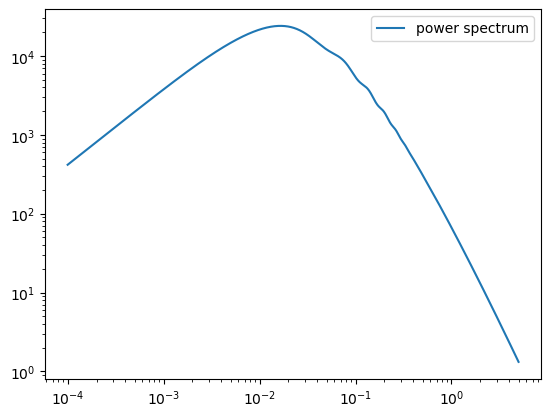

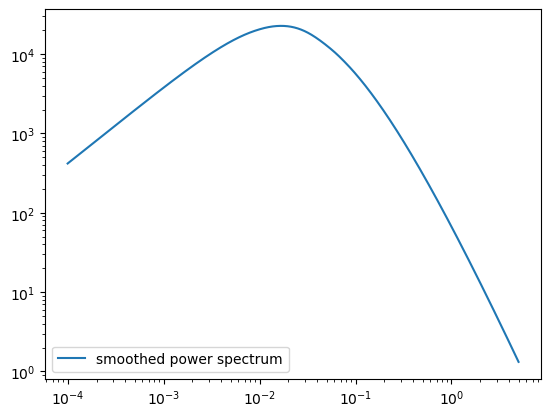

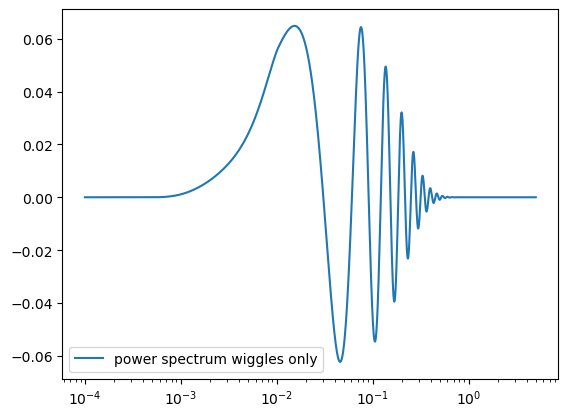

In [9]:
# Import the necessary packages and set up the fiducial cosmology
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from cosmoprimo.fiducial import DESI # package interface for CLASS and CAMB 
from scipy.interpolate import splrep, splev
from cosmoprimo import PowerSpectrumBAOFilter
from pypower import BaseMatrix, PowerSpectrumMultipoles, PowerSpectrumSmoothWindow, PowerSpectrumSmoothWindowMatrix, PowerSpectrumOddWideAngleMatrix, setup_logging
from pycorr import TwoPointCorrelationFunction, project_to_multipoles
cosmo = DESI() # initialize CLASS/CAMB like object for doing calculations of power spectrum etc. 
#print(dir(DESI()))
from matplotlib import rc
import matplotlib
plt.style.use('default')
from statsmodels.stats.moment_helpers import cov2corr



# Save the default DESI template to a file - added in code here to make sure the template is prepared properly 
k_min = 1e-4
k_max = 5
k_num = 2000
kl = np.logspace(np.log(k_min), np.log(k_max), k_num, base=np.e)
pkz = cosmo.get_fourier().pk_interpolator() # object to get power spectrum from interpolator 
pk = pkz.to_1d(z=0) # get power spectrum at z = 0 
pkv = pk(kl) 
plt.loglog(kl, pkv, label='power spectrum') # full broadband power spectrum + wiggles
plt.legend()
plt.show()
pknow = PowerSpectrumBAOFilter(pk, engine='wallish2018').smooth_pk_interpolator()
pksmv = pknow(kl) # interpolate smoothed power spectrum at desired k values 
plt.loglog(kl, pksmv, label='smoothed power spectrum') # smoothed broadband power spectrum without the wiggles (smoothed out) 
plt.legend()
plt.show()
np.savetxt("./DESI_Pk_template.dat", np.c_[kl, pksmv, pkv/pksmv - 1.0],  fmt="%g %g %g", header="k     pk_smooth     pk_ratio") # saving 
# the smoothed power spectrum and the ratio of the smooth to original to get the wiggles only - gets used later 


plt.semilogx(kl, pkv/pksmv - 1.0, label='power spectrum wiggles only')
plt.legend()
plt.show()


def plot_cov(matrix):
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    ''' Plot the correlation matrix derived from the covariance matrix '''
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.imshow(cov2corr(matrix), cmap=plt.get_cmap('bwr'))
    plt.colorbar()
    plt.clim(-1,1)
    plt.show()
    return 





# Power spectrum routines

In [8]:
# Power Spectrum. By Cristhian Garcia-Quintero, here we use an already rebinned Pk multipoles .txt file with the k-values and multipoles in a single file. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
def getpk_cgq(loc, zname, CV, post=False):
    seed = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09",
            "10", "11", "12", "13", "14", "15", "16", "17", "18", "19",
            "20", "21", "22", "23", "24"]
    res = []
    nmocks = len(seed)
    for i in range(nmocks): # looping through mocks and opening up 
        # Read data for a single mock
        if (CV == True and post==True):
            mydata = open(loc + '/' + zname + seed[i] + '.gcat_MultiGrid_mesh1024_smooth15_recsym_b1.2_randoms_20X.Pk_nmesh1152.ecsv', 'r')
        elif (CV == True and post==False):
            mydata = open(loc + '/' + zname + seed[i] + '.gcat.Pk_nmesh1152.ecsv', 'r')
        else:
            mydata = open(loc + '/' + zname + seed[i] + '.txt', 'r') 
        lines=mydata.readlines()
        k  = []
        P0 = []
        P2 = []
        P4 = []
        for line in lines: # looping through lines in file to save k, monopole, quadrupole and hexadecapole 
            if line.startswith('#'):
                if line[4:17]=='galaxy_number':
                    num_gal = float(line.split()[2])
                    num_ran = num_gal * 20
                    boxsize = 2000
                    nbar_gal = num_gal/boxsize**3
                    nbar_ran = num_ran/boxsize**3
                    shot_noise_gal = 1/nbar_gal
                    shot_noise_ran = 1/nbar_ran
                    shot_noise = shot_noise_gal + shot_noise_ran
                    print("num_gal:", num_gal, "nbar_gal:", nbar_gal, "Shot-Noise:", shot_noise)
            else:
                if (CV == True):
                    k.append(line.split()[0]) 
                    P0.append(line.split()[1]) 
                    P2.append(line.split()[2]) 
                    P4.append(line.split()[3]) 
                elif (post == True):
                    k.append(line.split()[1]) 
                    P0.append(line.split()[3]) 
                    P2.append(line.split()[5]) 
                    P4.append(line.split()[7]) 
                else:
                    k.append(line.split()[1]) 
                    P0.append(line.split()[3]) 
                    P2.append(line.split()[4]) 
                    P4.append(line.split()[5]) 
        mydata.close()
        if (CV == True):
            k=k[1:]
            P0=P0[1:]
            P2=P2[1:]
            P4=P4[1:]
        k  = np.array([float(i) for i in k])    
        P0 = np.array([float(i) for i in P0])    
        P2 = np.array([float(i) for i in P2])    
        P4 = np.array([float(i) for i in P4])   
        # Append 5 multipoles to result
        df = {}
        df["k"] = k
        if (CV == True):
            df[f"pk0"] = P0 - shot_noise
        else:
            df[f"pk0"] = P0
        df[f"pk2"] = P2
        df[f"pk4"] = P4
        df["pk1"] = np.zeros(len(df["k"])) # in dataframe save odd multipoles as zeros 
        df["pk3"] = np.zeros(len(df["k"]))
        res.append(pd.DataFrame(df)[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
         
    return res
    
# Window function matrix. The window functions are stored in a dictionary of 'step sizes' i.e., how many bins get stuck together relative to the 
# pk measurements so that we can rebin the P(k) at run time if required. Each step size is a dictionary with:
#    the input and output k binning (w_ks_input, w_ks_output), the window function matrix (w_transform) and integral constraint (w_k0_scale).
# The window function assumes 6 input and 5 output multipoles. For cubic sims, we can set the integral constraint to zero and window matrix to the identity matrix, as is done here.
def getwin_dummy(ks):
    res = {"w_ks_input": ks.copy(), "w_k0_scale": np.zeros(ks.size), "w_transform": np.eye(5 * ks.size, 6 * ks.size), "w_ks_output": ks.copy()}
    return {1: res}  # Step size is one

# The conversion matrix M from Beutler 2019. Used to compute the odd multipole models given the even multipoles. In the absence of wide angle effects, or if we don't care about
# the odd multipoles, we can set this to a block matrix with identity matrices in the appropriate places, as is done here.
def getcomp_dummy(ks):
    matrix = np.zeros((6 * ks.size, 3 * ks.size))
    matrix[: ks.size, : ks.size] = np.diag(np.ones(ks.size))
    matrix[2 * ks.size : 3 * ks.size, ks.size : 2 * ks.size] = np.diag(np.ones(ks.size))
    matrix[4 * ks.size : 5 * ks.size, 2 * ks.size :] = np.diag(np.ones(ks.size))
    return matrix

# Read's in Juan's k-space window multipoles and use the routines in pypower to convert these to window and wideangle matrices
def getwin(ks, winfile):
    
    wa_orders = 1 # wide-angle order
    ellsin = [0, 2, 4] # input (theory) multipoles
    ellsout = [0, 1, 2, 3, 4] # output multipoles
    
    # Check for the presence of window and wide angle matrix files already. If we find both, just load them in
    winmatname = winfile + "_matrix.npy"
    wideanglename = winfile + "_wideangle.npy"
    if os.path.exists(winmatname) and os.path.exists(wideanglename):
    
        wm = BaseMatrix.load(winmatname)
        wam = BaseMatrix.load(wideanglename)
        
    else: # need to calculate wide angle matrix, window matrix 

        window = PowerSpectrumSmoothWindow.load(winfile + ".npy") # PowerSpectrumSmoothWindow is a python class, 
        # here just loading window function file multipoles 

        sep = np.geomspace(1e-4, 1e4, 1024*16) # configuration space separation for FFTlog
        kin_rebin = 8 # rebin input theory to save memory, and run time when fitting.
        kin_lim = (1e-4, 0.4) # pre-cut input (theory) ks to save some memory
        projsin = ellsin + PowerSpectrumOddWideAngleMatrix.propose_out(ellsin, wa_orders=wa_orders)
        wm = PowerSpectrumSmoothWindowMatrix(ks, projsin=projsin, projsout=ellsout, window=window, sep=sep, kin_rebin=kin_rebin, kin_lim=kin_lim, default_zero=True)
        wam = PowerSpectrumOddWideAngleMatrix(wm.xin[0], projsin=ellsin, projsout=wm.projsin, d=1., wa_orders=wa_orders, los=window.attrs['los_type'])
        
        # Save the matrices
        wm.save(winmatname)
        wam.save(wideanglename)
    
    # The pypower functions store the inner chunks in the order 0, 2, 4, 1, 3, 5, 
    # but Barry expects 0, 1, 2, 3, 4, 5. So let's break the matrices apart and reorder them.
    wm_reshape = np.vsplit(wm.value, 6)
    wm_reshape = np.concatenate([wm_reshape[0],wm_reshape[3],wm_reshape[1],wm_reshape[4],wm_reshape[2],wm_reshape[5]]).T    
    wam_reshape = np.hsplit(wam.value, 6)
    wam_reshape = np.concatenate([wam_reshape[0],wam_reshape[3],wam_reshape[1],wam_reshape[4],wam_reshape[2],wam_reshape[5]], axis=1).T
    
    res = {"w_ks_input": wm.xin[0], "w_k0_scale": np.zeros(ks.size), "w_transform": wm_reshape, "w_ks_output": wm.xout[0]}
    winmat = {1: res}   # Step size is one, but we could modify this to contain other stepsizes too.
    return winmat, wam_reshape

# Power spectrum covariance matrix. Needs to have 6 multipoles, but if the some of them haven't been measured, we can set the covariance matrix elements to the identity matrix, as is done here.
def format_pk_cov(nks, covfile):

    cov_input = pd.read_csv(covfile, comment="#", delim_whitespace=True, header=None).to_numpy()
    nin = nks
    cov = np.eye(5 * nks)
    cov[:nks, :nks] = cov_input[:nks, :nks]
    cov[:nks, 2 * nks : 3 * nks] = cov_input[:nks, nin : nin + nks]
    cov[:nks, 4 * nks : 5 * nks] = cov_input[:nks, 2 * nin : 2 * nin + nks]
    cov[2 * nks : 3 * nks, :nks] = cov_input[nin : nin + nks, :nks]
    cov[2 * nks : 3 * nks, 2 * nks : 3 * nks] = cov_input[nin : nin + nks, nin : nin + nks]
    cov[2 * nks : 3 * nks, 4 * nks : 5 * nks] = cov_input[nin : nin + nks, 2 * nin : 2 * nin + nks]
    cov[4 * nks : 5 * nks, :nks] = cov_input[2 * nin : 2 * nin + nks, :nks]
    cov[4 * nks : 5 * nks, 2 * nks : 3 * nks] = cov_input[2 * nin : 2 * nin + nks, nin : nin + nks]
    cov[4 * nks : 5 * nks, 4 * nks : 5 * nks] = cov_input[2 * nin : 2 * nin + nks, 2 * nin : 2 * nin + nks]
    
    plt.imshow(cov/np.sqrt(np.outer(np.diag(cov), np.diag(cov))))
    plt.show()
    
    # Check the covariance matrix is invertible
    v = np.diag(cov @ np.linalg.inv(cov))
    if not np.all(np.isclose(v, 1)):
        print("ERROR, setting an inappropriate covariance matrix that is almost singular!!!!")
        #print(f"These should all be 1: {v}")
    
    return cov

# Useful utility function to collate some Pk data - simple read in data for multipoles for pre and post reconstruction 
# also read in file for the window function of the data 
def collect_pk_data(pre_files, post_files, pre_cov_files, post_cov_files, winfile, zeff, prezname, postzname, name, CV=False):
    
    ks = None
    pre_cov, post_cov = None, None
    pre_data, post_data = None, None
    pre_mocks, post_mocks = None, None
    if pre_files is not None:
        pre_res = getpk_cgq(pre_files, prezname, CV, post=False) 
        ks = pre_res[0]["k"].to_numpy()
        pre_cov = format_pk_cov(len(ks), pre_cov_file)
        pre_mocks = [v for v in pre_res]
    if post_files is not None:
        post_res = getpk_cgq(post_files, postzname, CV, post=True)
        ks = post_res[0]["k"].to_numpy() 
        post_cov = format_pk_cov(len(ks), post_cov_file)
        post_mocks = [v for v in post_res]

    if winfile is not None:
        winmat, wideangle = getwin(ks, winfile)
        wideangle = getcomp_dummy(ks)
    else:
        winmat, wideangle = getwin_dummy(ks), getcomp_dummy(ks)
    
    split = {
        "n_data": 1,
        "pre-recon data": pre_data,
        "pre-recon cov": pre_cov,
        "post-recon data": post_data,
        "post-recon cov": post_cov,
        "pre-recon mocks": pre_mocks,
        "post-recon mocks": post_mocks,
        "cosmology": {
            "om": cosmo["Omega_m"],
            "h0": cosmo["h"],
            "z": zeff,
            "ob": cosmo["Omega_b"],
            "ns": cosmo["n_s"],
            "mnu": np.sum(cosmo["m_ncdm"]),
            "reconsmoothscale": 15,
        },
        "name": name,
        "winfit": winmat,
        "winpk": None,  # We can set this to None; Barry will set it to zeroes given the length of the data vector.
        "m_mat": wideangle,
    }
    
    with open(f"./" + name.lower().replace(" ", "_")+".pkl", "wb") as f:
        pickle.dump(split, f)
        
    return split # writing read in file sand other results that are relevant to pickle file and returning 

# Plot the power spectra, for sanity checking
def plot_pk(split, pre=True, post=True):
    
    if pre:
        color = ["r", "b", "g"]
        ks = split["pre-recon mocks"][0]["k"]
        nmocks = len(split["pre-recon mocks"])
        label = [r"$P_{0}(k)$", r"$P_{2}(k)$", r"$P_{4}(k)$"]
        for m, pk in enumerate(["pk0", "pk2", "pk4"]): # looping and plotting each multipole mean value 
            yerr = ks * np.sqrt(np.diag(split["pre-recon cov"]))[2 * m * len(ks) : (2 * m + 1) * len(ks)]
            plt.errorbar(
                ks,
                ks * np.mean([split["pre-recon mocks"][i][pk] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks): # each mock plotted multipole x ks array 
                plt.errorbar(ks, ks * split["pre-recon mocks"][i][pk], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$k$")
        plt.ylabel(r"$k\,P(k)$")
        plt.title(split["name"] + " Prerecon")
        plt.legend(loc='upper right')
        plt.show()
    
    if post:
        color = ["r", "b", "g"]
        ks = split["post-recon mocks"][0]["k"]
        nmocks = len(split["post-recon mocks"])
        label = [r"$P_{0}(k)$", r"$P_{2}(k)$", r"$P_{4}(k)$"]
        for m, pk in enumerate(["pk0", "pk2", "pk4"]):
            yerr = ks * np.sqrt(np.diag(split["post-recon cov"]))[2 * m * len(ks) : (2 * m + 1) * len(ks)]
            plt.errorbar(
                ks,
                ks * np.mean([split["post-recon mocks"][i][pk] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ks, ks * split["post-recon mocks"][i][pk], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$k$")
        plt.ylabel(r"$k\,P(k)$")
        plt.title(split["name"] + " Postrecon")
        plt.legend(loc='upper right')
        plt.show()

# Correlation function routines

In [9]:
# Power Spectrum. By Cristhian Garcia-Quintero, here we use an already rebinned Pk multipoles .txt file with the k-values and multipoles in a single file. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
def getxi_cgq(loc, zname, recon, RascalC, CV, post):
    seed = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09",
            "10", "11", "12", "13", "14", "15", "16", "17", "18", "19",
            "20", "21", "22", "23", "24"]
    res = []
    nmocks = len(seed)
    for i in range(nmocks):
        # Read data for a single mock
        mydata = open(loc + '/' + zname + seed[i] + '.txt', 'r') 
        lines=mydata.readlines()
        s  = []
        Xi0 = []
        Xi2 = []
        Xi4 = []
        for line in lines: 
            if line.startswith('#'):
                pass
            else:
                if (CV == True):
                    s.append(line.split()[0]) 
                    Xi0.append(line.split()[1]) 
                    Xi2.append(line.split()[2]) 
                    Xi4.append(line.split()[3]) 
                else:
                    s.append(line.split()[0]) 
                    Xi0.append(line.split()[2]) 
                    Xi2.append(line.split()[3]) 
                    Xi4.append(line.split()[4]) 
        mydata.close()
        s  = np.array([float(i) for i in s])    
        Xi0 = np.array([float(i) for i in Xi0])    
        Xi2 = np.array([float(i) for i in Xi2])    
        Xi4 = np.array([float(i) for i in Xi4])   
        if (RascalC == True):
            s = s[5:]
            Xi0 = Xi0[5:]
            Xi2 = Xi2[5:]
            Xi4 = Xi4[5:]
        # Append 5 multipoles to result ????????? 
        df = {}
        df["s"] = s
        df[f"xi0"] = Xi0
        df[f"xi2"] = Xi2
        df[f"xi4"] = Xi4
        res.append(pd.DataFrame(df)[["s", "xi0", "xi2", "xi4"]])
         
    return res

# Correlation function covariance matrix.
def format_xi_cov(nss, covfile):

    cov_input = pd.read_csv(covfile, comment="#", delim_whitespace=True, header=None).to_numpy()
    nin = nss
    cov = np.zeros((3 * nss, 3 * nss))
    cov[:nss, :nss] = cov_input[:nss, :nss]
    cov[:nss, nss : 2 * nss] = cov_input[:nss, nin : nin + nss]
    cov[:nss, 2 * nss :] = cov_input[:nss, 2 * nin : 2 * nin + nss]
    cov[nss : 2 * nss, :nss] = cov_input[nin : nin + nss, :nss]
    cov[nss : 2 * nss, nss : 2 * nss] = cov_input[nin : nin + nss, nin : nin + nss]
    cov[nss : 2 * nss, 2 * nss :] = cov_input[nin : nin + nss, 2 * nin : 2 * nin + nss]
    cov[2 * nss :, :nss] = cov_input[2 * nin : 2 * nin + nss, :nss]
    cov[2 * nss :, nss : 2 * nss] = cov_input[2 * nin : 2 * nin + nss, nin : nin + nss]
    cov[2 * nss :, 2 * nss :] = cov_input[2 * nin : 2 * nin + nss, 2 * nin : 2 * nin + nss]
    
    plt.imshow(cov/np.sqrt(np.outer(np.diag(cov), np.diag(cov))))
    plt.show()
    
    # Check the covariance matrix is invertible
    v = np.diag(cov @ np.linalg.inv(cov))
    if not np.all(np.isclose(v, 1)):
        print("ERROR, setting an inappropriate covariance matrix that is almost singular!!!!")
        #print(f"These should all be 1: {v}")

    return cov

# Useful utility function to collate some Xi data
def collect_xi_data(pre_files, post_files, pre_cov_file, post_cov_file, zeff, prezname, postzname, name, RascalC=False, CV=False):

    pre_cov, post_cov = None, None
    pre_data, post_data = None, None
    pre_mocks, post_mocks = None, None
    if pre_files is not None:
        pre_res = getxi_cgq(pre_files, prezname, 'pre', RascalC, CV, post=False)
        ss = pre_res[0]["s"].to_numpy()
        pre_cov = format_xi_cov(len(ss), pre_cov_file)
        pre_mocks = [v for v in pre_res]
    if post_files is not None:
        post_res = getxi_cgq(post_files, postzname, 'post', RascalC, CV, post=True)
        ss = post_res[0]["s"].to_numpy()
        post_cov = format_xi_cov(len(ss), post_cov_file)
        post_mocks = [v for v in post_res]   
    split = {
        "n_data": 1,
        "pre-recon data": pre_data,
        "pre-recon cov": pre_cov,
        "post-recon data": post_data,
        "post-recon cov": post_cov,
        "pre-recon mocks": pre_mocks,
        "post-recon mocks": post_mocks,
        "cosmology": {
            "om": cosmo["Omega_m"],
            "h0": cosmo["h"],
            "z": zeff,
            "ob": cosmo["Omega_b"],
            "ns": cosmo["n_s"],
            "mnu": np.sum(cosmo["m_ncdm"]),
            "reconsmoothscale": 15,
        },
        "name": name,
    }
    
    with open(f"./" + name.lower().replace(" ", "_")+".pkl", "wb") as f:
        pickle.dump(split, f)
        
    return split
    
# Plot the power spectra, for sanity checking
def plot_xi(split, pre=True, post=True):
    
    if pre:
    
        color = ["r", "b", "g"]
        ss = split["pre-recon mocks"][0]["s"]
        nmocks = len(split["pre-recon mocks"])
        label = [r"$\xi_{0}(k)$", r"$\xi_{2}(k)$", r"$\xi_{4}(k)$"]
        for m, xi in enumerate(["xi0", "xi2", "xi4"]):
            yerr = ss ** 2 * np.sqrt(np.diag(split["pre-recon cov"]))[m * len(ss) : (m + 1) * len(ss)]
            plt.errorbar(
                ss,
                ss ** 2 * np.mean([split["pre-recon mocks"][i][xi] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ss, ss ** 2 * split["pre-recon mocks"][i][xi], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$s$")
        plt.ylabel(r"$s^{2}\,\xi(s)$")
        plt.title(split["name"] + " Prerecon")
        plt.legend(loc='upper right')
        plt.show()
        
    if post:
        
        color = ["r", "b", "g"]
        ss = split["post-recon mocks"][0]["s"]
        nmocks = len(split["post-recon mocks"])
        label = [r"$\xi_{0}(k)$", r"$\xi_{2}(k)$", r"$\xi_{4}(k)$"]
        for m, xi in enumerate(["xi0", "xi2", "xi4"]):
            yerr = ss ** 2 * np.sqrt(np.diag(split["post-recon cov"]))[m * len(ss) : (m + 1) * len(ss)]
            plt.errorbar(
                ss,
                ss ** 2 * np.mean([split["post-recon mocks"][i][xi] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ss, ss ** 2 * split["post-recon mocks"][i][xi], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$s$")
        plt.ylabel(r"$s^{2}\,\xi(s)$")
        plt.title(split["name"] + " Postrecon")
        plt.legend(loc='upper right')
        plt.show()

# Produce Pickles

Default HOD (Pk and Xi)

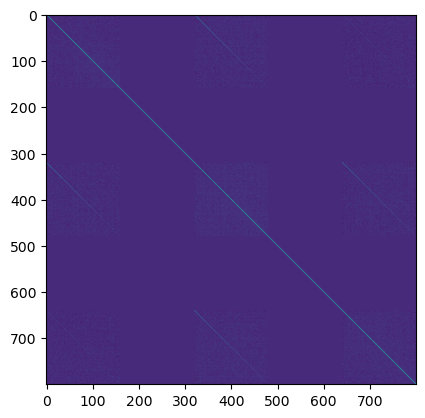

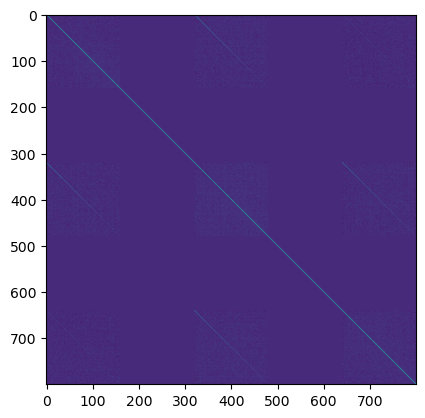

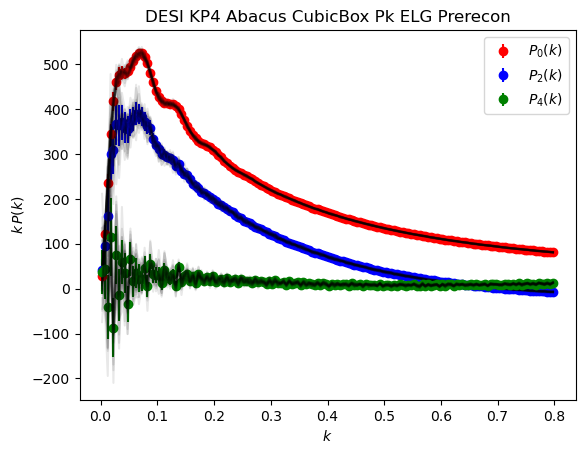

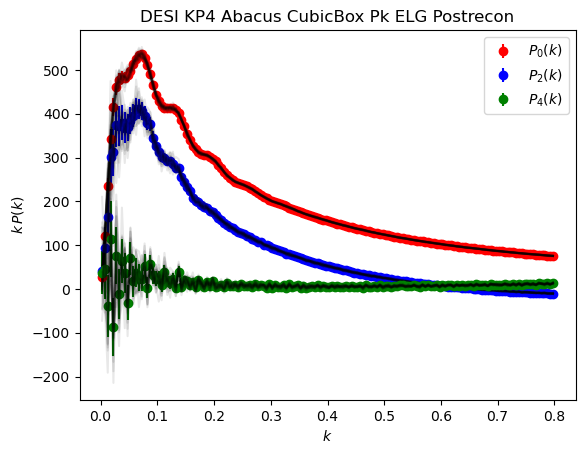

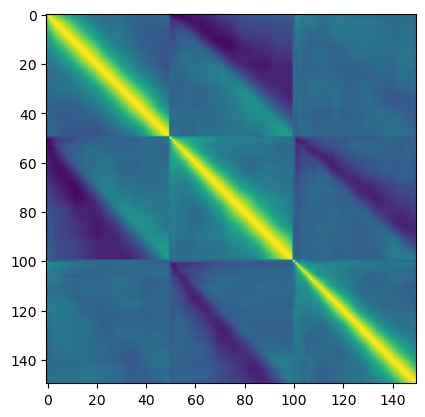

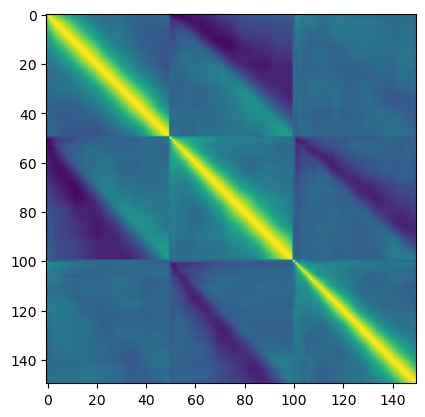

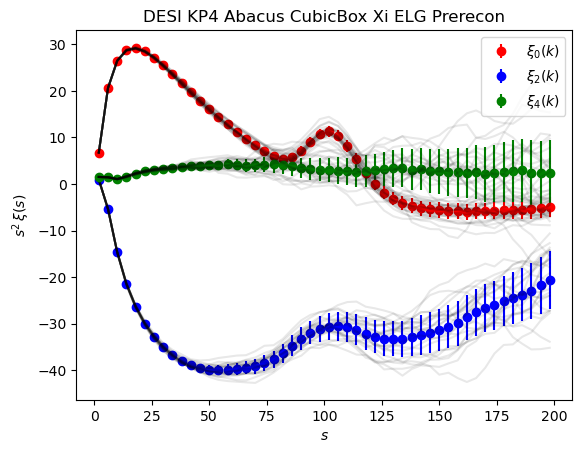

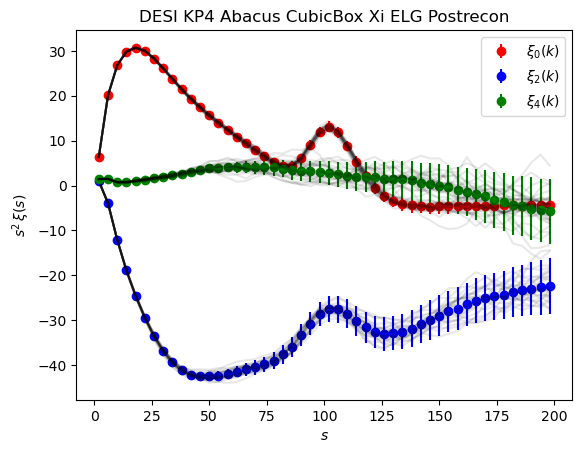

In [16]:
# Loop over tracers
path_abacus = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/"
path_ezmock = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/EZMocks/"

# Dictionary containing z for the tracers
reds = {"ELG": [1.1]}

for tracer in ["ELG"]:
    for i, z in enumerate(reds[tracer]):
    
        # Power Spectrum
        # pre reconstruction file paths 
        pre_file = path_abacus + tracer + "/Pk/Pre/Cristhian/txt_rebinned/"
        
        pre_cov_file = path_ezmock + "EZmocks_ELG_CubicBox_z1p1_Pk_cov_matrix_reshaped_pk-pre.txt"  # Uses the EZmock covariance
        
        # post reconstruction file paths 
        post_file = path_abacus + tracer + "/Pk/Post/Cristhian/recsym/txt_rebinned/" # was missing recsym directory initially 
        
        post_cov_file = path_ezmock + "EZmocks_ELG_CubicBox_z1p1_Pk_cov_matrix_reshaped_pk-pre.txt"  # Uses the Prerecon EZmock covariance
        name = f"DESI KP4 Abacus CubicBox Pk " + tracer
        
        data = collect_pk_data(pre_file, post_file, pre_cov_file, post_cov_file, None, z, "Pk_ELGlowDens_Abacus_c000_ph0",
                               "Pk_ELGlowDens_recsym_Abacus_c000_ph0", name, CV=False)
        plot_pk(data) # Plot the data to check things

        
        
        
        # Correlation Function
        pre_file = path_abacus + tracer + f"/Xi/Pre/lhior/txt_rebinned"
        pre_cov_file = path_ezmock + "EZmocks_ELG_CubicBox_z1p1_Xi_cov_matrix_reshaped-pre.txt"  # Uses the EZmock covariance
        
        post_file = path_abacus + tracer + "/Xi/Post/lhior/RecSym_nmesh1024/txt_rebinned"
        post_cov_file = path_ezmock + "EZmocks_ELG_CubicBox_z1p1_Xi_cov_matrix_reshaped-pre.txt"  # Uses the Prerecon EZmock covariance
        
        name = f"DESI KP4 Abacus CubicBox Xi " + tracer
        data = collect_xi_data(pre_file, post_file, pre_cov_file, post_cov_file, z, "Xi_AbacusSummit_base_c000_ph0",
                               "Xi_AbacusSummit_base_c000_ph0", name)
        plot_xi(data) # Plot the data to check things
        
        

Default HOD (Xi) with RascalC covariance

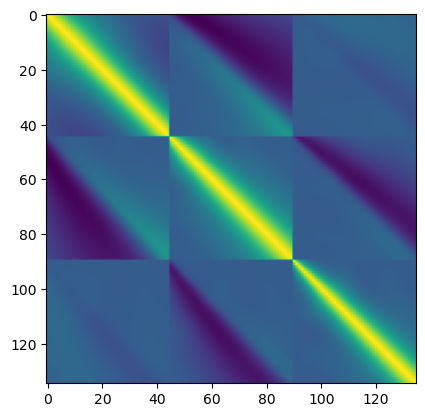

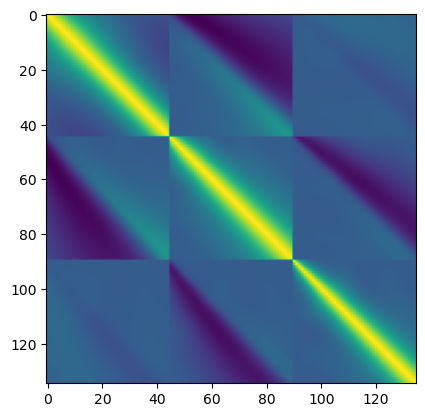

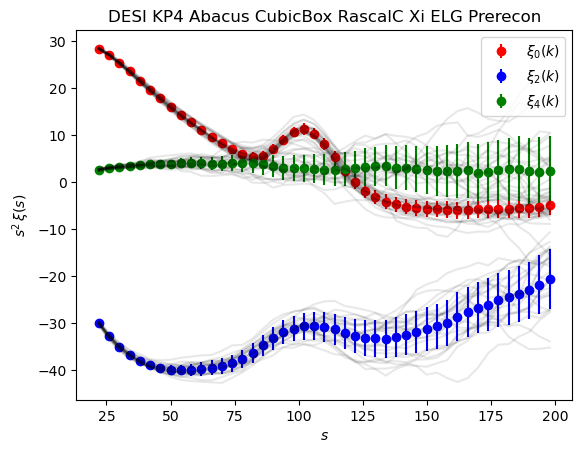

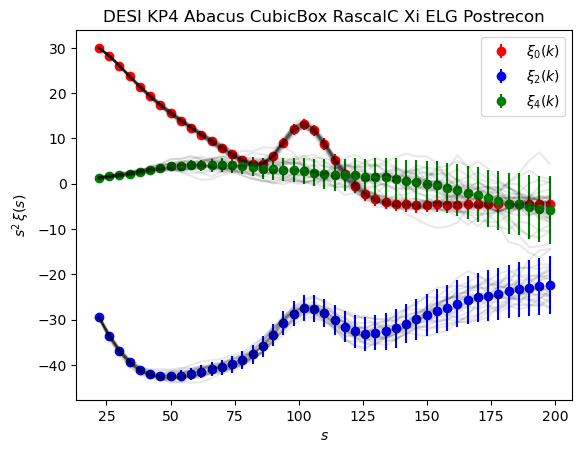

In [17]:
# Loop over tracers
path_abacus = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/"
path_rascalC = "/global/cfs/projectdirs/desi/users/mrash/RascalC/AbacusSummit/CubicBox/"

# Dictionary containing z for the tracers
reds = {"ELG": [1.1]}

for tracer in ["ELG"]:
    for i, z in enumerate(reds[tracer]):

        # Correlation Function
        pre_file = path_abacus + tracer + f"/Xi/Pre/lhior/txt_rebinned"
        pre_cov_file = path_rascalC + "xi024_ELG_EZmocks_lin4_s20-200_cov_RascalC_Gaussian.txt"
        post_file = path_abacus + tracer + "/Xi/Post/lhior/RecSym_nmesh1024/txt_rebinned"
        post_cov_file = path_rascalC + "xi024_ELG_EZmocks_lin4_s20-200_cov_RascalC_Gaussian.txt"
        name = f"DESI KP4 Abacus CubicBox RascalC Xi " + tracer
        data = collect_xi_data(pre_file, post_file, pre_cov_file, post_cov_file, z, "Xi_AbacusSummit_base_c000_ph0", 
                               "Xi_AbacusSummit_base_c000_ph0", name, RascalC=True)
        plot_xi(data) # Plot the data to check things

Default HOD (Pk) with Control Variance reduced-noise measurements

num_gal: 23996301.0 nbar_gal: 0.002999537625 Shot-Noise: 350.05395206536207
num_gal: 24000124.0 nbar_gal: 0.0030000155 Shot-Noise: 349.99819167600964
num_gal: 24007343.0 nbar_gal: 0.003000917875 Shot-Noise: 349.8929473369877
num_gal: 24000282.0 nbar_gal: 0.00300003525 Shot-Noise: 349.9958875483213
num_gal: 23995036.0 nbar_gal: 0.0029993795 Shot-Noise: 350.07240664277396
num_gal: 23998887.0 nbar_gal: 0.002999860875 Shot-Noise: 350.0162320027591
num_gal: 23999584.0 nbar_gal: 0.002999948 Shot-Noise: 350.006066771824
num_gal: 24003189.0 nbar_gal: 0.003000398625 Shot-Noise: 349.95349992869694
num_gal: 24007205.0 nbar_gal: 0.003000900625 Shot-Noise: 349.8949586176317
num_gal: 24004310.0 nbar_gal: 0.00300053875 Shot-Noise: 349.9371571188674
num_gal: 24004901.0 nbar_gal: 0.003000612625 Shot-Noise: 349.92854167571863
num_gal: 23996644.0 nbar_gal: 0.0029995805 Shot-Noise: 350.0489485113002
num_gal: 23999476.0 nbar_gal: 0.0029999345 Shot-Noise: 350.0076418335134
num_gal: 24001474.0 nbar_gal: 0.00

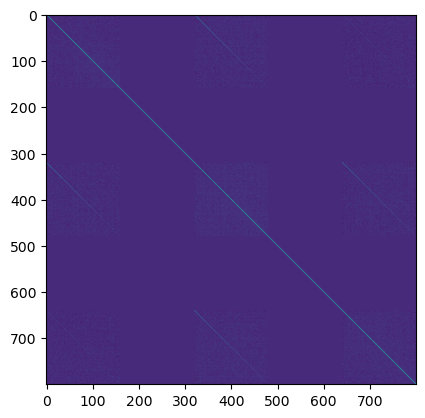

num_gal: 23996301.0 nbar_gal: 0.002999537625 Shot-Noise: 350.05395206536207
num_gal: 24000124.0 nbar_gal: 0.0030000155 Shot-Noise: 349.99819167600964
num_gal: 24007343.0 nbar_gal: 0.003000917875 Shot-Noise: 349.8929473369877
num_gal: 24000282.0 nbar_gal: 0.00300003525 Shot-Noise: 349.9958875483213
num_gal: 23995036.0 nbar_gal: 0.0029993795 Shot-Noise: 350.07240664277396
num_gal: 23998887.0 nbar_gal: 0.002999860875 Shot-Noise: 350.0162320027591
num_gal: 23999584.0 nbar_gal: 0.002999948 Shot-Noise: 350.006066771824
num_gal: 24003189.0 nbar_gal: 0.003000398625 Shot-Noise: 349.95349992869694
num_gal: 24007205.0 nbar_gal: 0.003000900625 Shot-Noise: 349.8949586176317
num_gal: 24004310.0 nbar_gal: 0.00300053875 Shot-Noise: 349.9371571188674
num_gal: 24004901.0 nbar_gal: 0.003000612625 Shot-Noise: 349.92854167571863
num_gal: 23996644.0 nbar_gal: 0.0029995805 Shot-Noise: 350.0489485113002
num_gal: 23999476.0 nbar_gal: 0.0029999345 Shot-Noise: 350.0076418335134
num_gal: 24001474.0 nbar_gal: 0.00

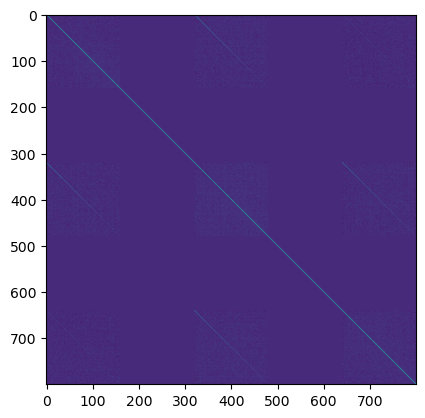

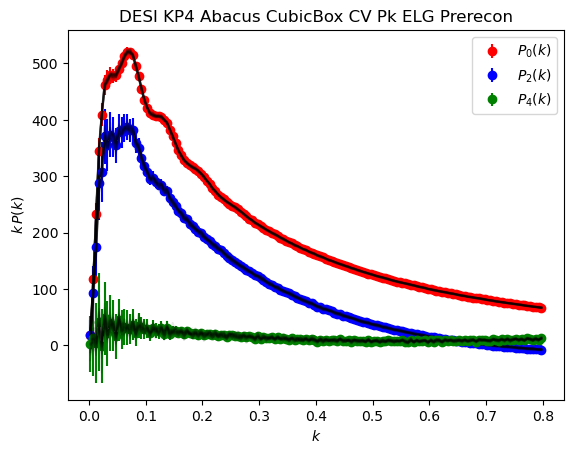

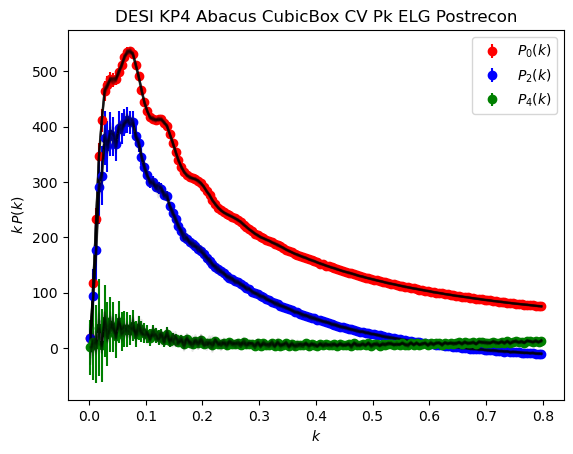

In [18]:
# Loop over tracers
path_CV = '/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/ELG/Pk_CV/'
path_ezmock = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/EZMocks/"

# Dictionary containing z for the tracers
reds = {"ELG": [1.1]}

for tracer in ["ELG"]:
    for i, z in enumerate(reds[tracer]):
    
        # Power Spectrum
        pre_file = path_CV + 'Pre/boryanah/'
        pre_cov_file = path_ezmock + "/EZmocks_ELG_CubicBox_z1p1_Pk_cov_matrix_reshaped_pk-pre.txt"
        post_file = path_CV + 'Post/boryanah/'
        post_cov_file = path_ezmock + "/EZmocks_ELG_CubicBox_z1p1_Pk_cov_matrix_reshaped_pk-pre.txt"
        name = f"DESI KP4 Abacus CubicBox CV Pk " + tracer
        data = collect_pk_data(pre_file, post_file, pre_cov_file, post_cov_file, None, z, "ELGlowDens_snap16_ph0",
                               "ELG_snap16_ph0", name, CV=True)
        plot_pk(data) # Plot the data to check things

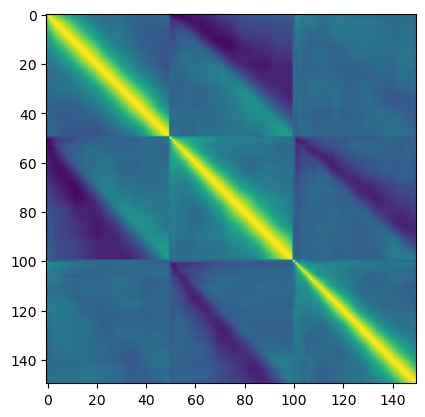

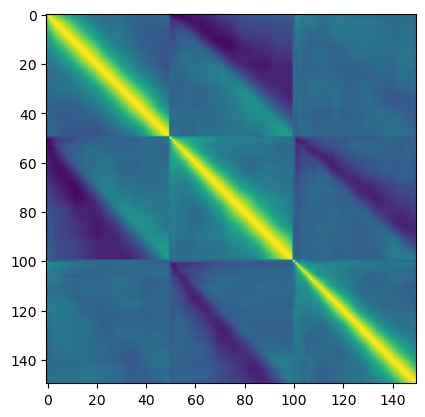

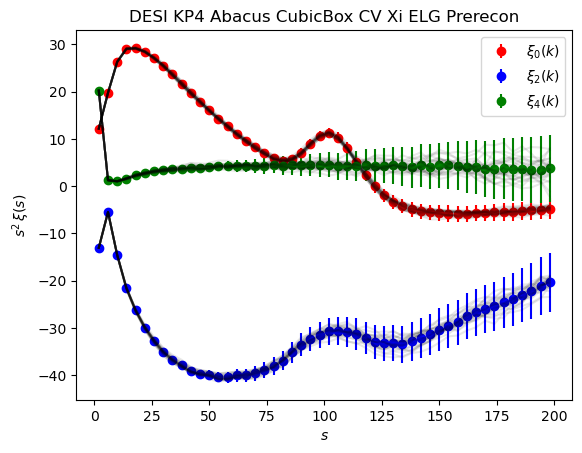

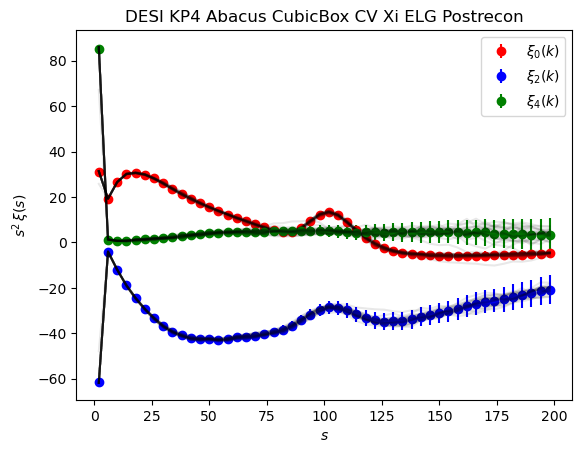

In [19]:
# Loop over tracers
path_abacus = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/"
path_ezmock = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/EZMocks/"

# Dictionary containing z for the tracers
reds = {"ELG": [1.1]}

for tracer in ["ELG"]:
    for i, z in enumerate(reds[tracer]):
        # Correlation Function
        pre_file = path_abacus + tracer + "/Xi/Pre/HOD/rebinned_CV/default/"
        pre_cov_file = path_ezmock + "EZmocks_ELG_CubicBox_z1p1_Xi_cov_matrix_reshaped-pre.txt"  # Uses the EZmock covariance
        post_file = path_abacus + tracer + "/Xi/Post/HOD/rebinned_CV/default/"
        post_cov_file = path_ezmock + "EZmocks_ELG_CubicBox_z1p1_Xi_cov_matrix_reshaped-pre.txt"  # Uses the Prerecon EZmock covariance
        name = f"DESI KP4 Abacus CubicBox CV Xi " + tracer
        data = collect_xi_data(pre_file, post_file, pre_cov_file, post_cov_file, z, "Xi_Abacus_CubicBox_ph0", 
                               "Xi_Abacus_CubicBox_ph0", name, CV=True)
        plot_xi(data) # Plot the data to check things